In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import os
import joblib
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

In [2]:
plt.rcParams["axes.unicode_minus"] = False

if platform.system() == "Darwin":  # macOS
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":  # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
elif platform.system() == "Linux":  # Linux (Ubuntu, Docker 등)
    font_path = "fonts/NanumGothic.ttf"
    if not os.path.exists(font_path):
        st.error("NanumGothic.ttf 폰트 파일이 존재하지 않습니다. 'fonts' 폴더 내에 폰트 파일을 확인하세요.")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

Epoch 1/1000


/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1425  
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1069 
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0579 
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0266 
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0275
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245 
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 
Epoch 12/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247 
Epoch 13/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 
Epoch 14/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 
Epoch 15/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244 
Epoch 16/1000
7/

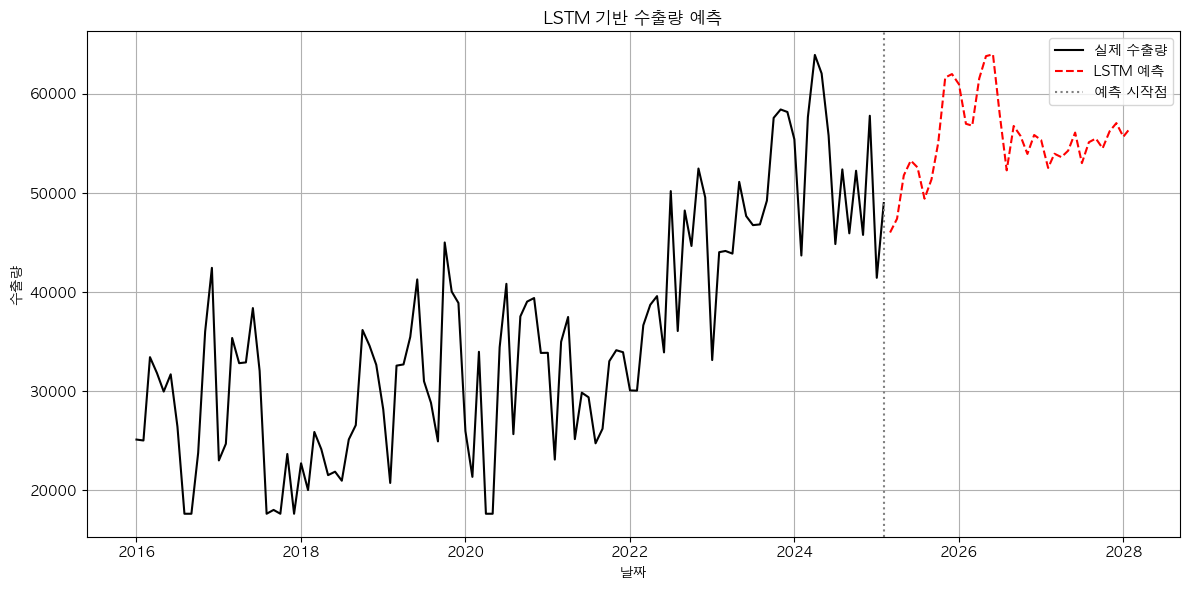

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. 데이터 준비 함수
def prepare_lstm_data(series, time_steps=12):
    values = series['y'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(time_steps, len(scaled)):
        X.append(scaled[i-time_steps:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# 2. 모델 정의 및 학습
def train_lstm_model(X, y, units=50, epochs=1000, batch_size=16):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# 3. 미래 예측
def forecast_lstm(model, series, forecast_months, scaler, time_steps=12):
    data = scaler.transform(series['y'].values.reshape(-1, 1))
    last_sequence = data[-time_steps:]

    predictions = []
    for _ in range(forecast_months):
        input_seq = last_sequence.reshape(1, time_steps, 1)
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0, 0])
        last_sequence = np.append(last_sequence[1:], pred, axis=0)

    forecast_scaled = np.array(predictions).reshape(-1, 1)
    forecast_values = scaler.inverse_transform(forecast_scaled)

    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_months, freq='MS')

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 수출량': forecast_values.flatten()
    })
    return result

# 4. 시각화 함수
def plot_lstm_forecast(series, forecast_df):
    forecast_index = pd.to_datetime(forecast_df['연도'].astype(str) + '-' + forecast_df['월'].astype(str))
    forecast_values = forecast_df['예측 수출량'].values

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series['y'], label='실제 수출량', color='black')
    plt.plot(forecast_index, forecast_values, label='LSTM 예측', color='red', linestyle='--')
    plt.axvline(x=series.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title("LSTM 기반 수출량 예측")
    plt.xlabel("날짜")
    plt.ylabel("수출량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. 실행 예시
file_path = "../../data/processed/현대_지역별수출실적_전처리.csv"
df = pd.read_csv(file_path)

# 전처리: 지역명 + 대륙 통합
df['지역명'] = df['지역명'].astype(str) + '-' + df['대륙'].astype(str).str.zfill(2)
df = df.drop(columns=['대륙'])
cols = ['지역명'] + [col for col in df.columns if col != '지역명']
df = df[cols]

region_name = "미국-북미"
forecast_months = 36

region_data = df[df['지역명'] == region_name].iloc[:, 1:].T
region_data.columns = ['y']
region_data.index = pd.to_datetime(region_data.index)
region_data = region_data.asfreq('MS')
region_data['y'] = pd.to_numeric(region_data['y'], errors='coerce')
region_data = region_data.dropna()

# 학습 및 예측
X, y, scaler = prepare_lstm_data(region_data)
lstm_model = train_lstm_model(X, y)
lstm_forecast = forecast_lstm(lstm_model, region_data, forecast_months, scaler)

# 출력 및 시각화
print(lstm_forecast)
plot_lstm_forecast(region_data, lstm_forecast)

In [63]:
lstm_model.save("../../models/lstm_region_model.h5")
joblib.dump(scaler, "../../models/lstm_region_scaler.pkl")

# 불러오기
from tensorflow.keras.models import load_model
new_model = load_model("../../models/lstm_region_model.h5", compile=False)
new_scaler = joblib.load("../../models/lstm_region_scaler.pkl")

      연도   월        예측 수출량
0   2025   3  46023.945312
1   2025   4  47415.652344
2   2025   5  51788.148438
3   2025   6  53280.074219
4   2025   7  52586.949219
5   2025   8  49436.539062
6   2025   9  51382.898438
7   2025  10  55087.429688
8   2025  11  61659.875000
9   2025  12  62006.218750
10  2026   1  60977.851562
11  2026   2  56990.996094
12  2026   3  56799.589844
13  2026   4  61562.054688
14  2026   5  63816.097656
15  2026   6  64001.308594
16  2026   7  57943.191406
17  2026   8  52296.386719
18  2026   9  56770.476562
19  2026  10  55782.214844
20  2026  11  53949.195312
21  2026  12  55862.390625
22  2027   1  55352.308594
23  2027   2  52539.164062


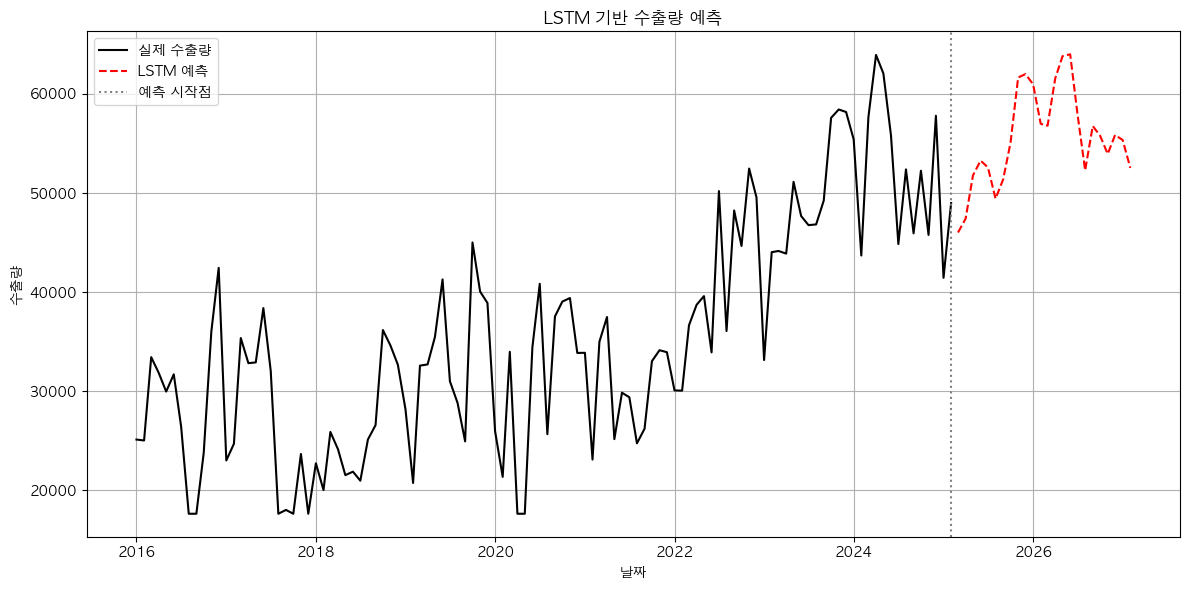

In [67]:
region_data = df[df['지역명'] == "미국-북미"].iloc[:, 1:].T
region_data.columns = ['y']
region_data.index = pd.to_datetime(region_data.index)
region_data = region_data.asfreq('MS')
region_data['y'] = pd.to_numeric(region_data['y'], errors='coerce')
region_data = region_data.dropna()

lstm_forecast = forecast_lstm(new_model, region_data, 24, new_scaler)
print(lstm_forecast)
plot_lstm_forecast(region_data, lstm_forecast)

## 아래는 테스트 모델

      연도   월        예측 수출량
0   2025   3  53252.471835
1   2025   4  55170.790244
2   2025   5  54650.047584
3   2025   6  53951.589822
4   2025   7  52849.614930
5   2025   8  50286.194662
6   2025   9  51943.163059
7   2025  10  57411.268031
8   2025  11  57449.622463
9   2025  12  59407.975469
10  2026   1  50400.587064
11  2026   2  50529.618204
12  2026   3  58076.090309
13  2026   4  59234.188070
14  2026   5  58936.716668
15  2026   6  57995.690831
16  2026   7  56625.241544
17  2026   8  54353.806534
18  2026   9  55772.848107
19  2026  10  61265.396939
20  2026  11  61111.157952
21  2026  12  63367.336851
22  2027   1  54142.642740
23  2027   2  54491.132696
24  2027   3  61940.204606
25  2027   4  63120.808550
26  2027   5  62816.727247
27  2027   6  61882.882684
28  2027   7  60520.381682
29  2027   8  58240.302348
30  2027   9  59666.387825
31  2027  10  65158.212988
32  2027  11  65009.675793
33  2027  12  67257.037458
34  2028   1  58038.776755
35  2028   2  58380.769558


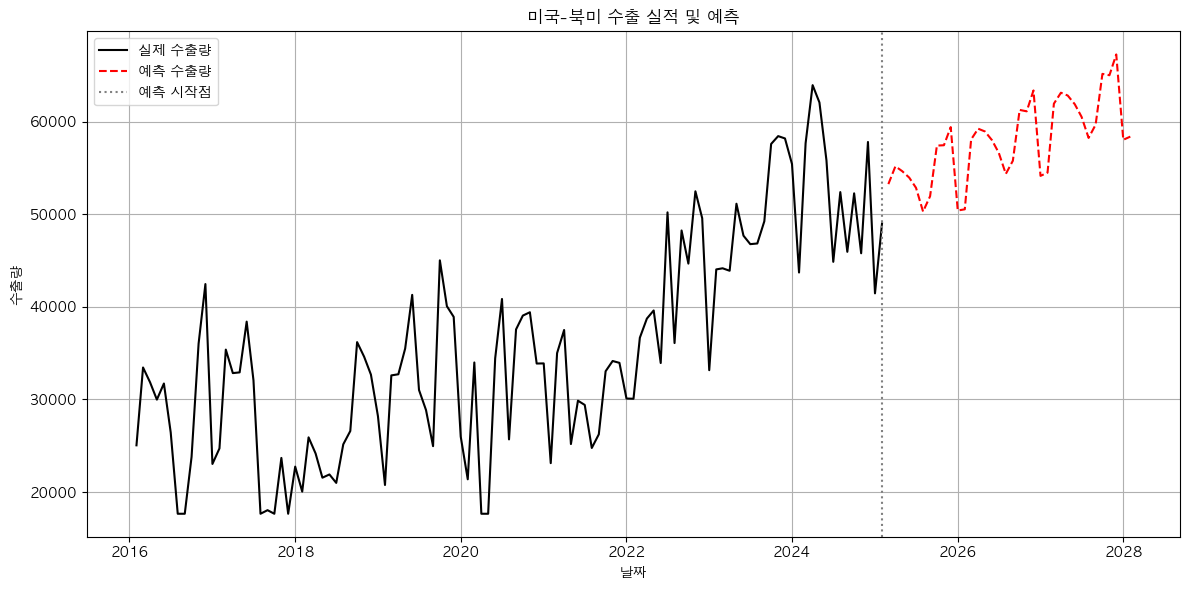

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def prepare_region_series(df, region_name):
    region_data = df[df['지역명'] == region_name].iloc[:, 2:].T
    region_data.columns = ['y']
    region_data.index = pd.to_datetime(region_data.index)
    region_data = region_data.asfreq('MS')
    return region_data

def train_sarimax_model(series):
    # (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,12): 기본 계절성 모델
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fit_model = model.fit(disp=False)
    return fit_model

def forecast_future(fit_model, series, periods):
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast = fit_model.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 수출량': forecast_mean.values
    })
    return result


file_path = "../../data/processed/현대_지역별수출실적_전처리.csv"  # 본인 환경에 맞게 경로 설정
region_name = "미국-북미"  # 입력받을 지역명
forecast_months = 36   # 예측할 개월 수

df = load_data(file_path)
df['지역명'] = df['지역명'].astype(str) + '-' + df['대륙'].astype(str).str.zfill(2)

# 기존 컬럼 제거
df = df.drop(columns=['대륙'])

# '날짜' 컬럼을 맨 앞으로 이동
cols = ['지역명'] + [col for col in df.columns if col != '지역명']
df = df[cols]
region_series = prepare_region_series(df, region_name)
model = train_sarimax_model(region_series)
forecast_result = forecast_future(model, region_series, forecast_months)

print(forecast_result)

import matplotlib.pyplot as plt

def plot_series_with_forecast(series, forecast_result, region_name):
    # 실제값
    actual = series.copy()
    
    # 예측 날짜 구성
    forecast_index = pd.to_datetime(forecast_result['연도'].astype(str) + '-' + forecast_result['월'].astype(str))
    forecast_series = pd.Series(forecast_result['예측 수출량'].values, index=forecast_index)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual['y'], label='실제 수출량', color='black')
    plt.plot(forecast_series.index, forecast_series.values, label='예측 수출량', color='red', linestyle='--')
    
    plt.axvline(x=actual.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title(f"{region_name} 수출 실적 및 예측")
    plt.xlabel("날짜")
    plt.ylabel("수출량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_series_with_forecast(region_series, forecast_result, region_name)

In [20]:
df = pd.read_csv("../../data/processed/통합 문서6.csv")  # 실제 경로로 수정
df['차량'] = df['차종'].astype(str) + '-' + df['차량 유형'].astype(str).str.zfill(2) + '-' + df['거래 구분'].astype(str).str.zfill(2)

# 기존 컬럼 제거
df = df.drop(columns=['차종', '차량 유형', '거래 구분'])

# '날짜' 컬럼을 맨 앞으로 이동
cols = ['차량'] + [col for col in df.columns if col != '차량']
df = df[cols]

      연도   월      예측 수출량
0   2025   3  145.787246
1   2025   4  167.163654
2   2025   5  135.050433
3   2025   6  119.422412
4   2025   7  159.717586
5   2025   8  166.514905
6   2025   9  140.890737
7   2025  10  146.782131
8   2025  11  155.951645
9   2025  12  145.267280
10  2026   1  113.555317
11  2026   2  122.301303
12  2026   3  192.298351
13  2026   4  216.988126
14  2026   5  163.663557
15  2026   6  143.692849
16  2026   7  177.527234
17  2026   8  183.756537
18  2026   9  167.202755
19  2026  10  167.536731
20  2026  11  171.249280
21  2026  12  155.487665
22  2027   1  122.942331
23  2027   2  137.021491
24  2027   3  206.063281
25  2027   4  230.314058
26  2027   5  179.799781
27  2027   6  160.404436
28  2027   7  195.094812
29  2027   8  201.399371
30  2027   9  183.643852
31  2027  10  184.714131
32  2027  11  189.149675
33  2027  12  174.060745
34  2028   1  141.625825
35  2028   2  154.998392


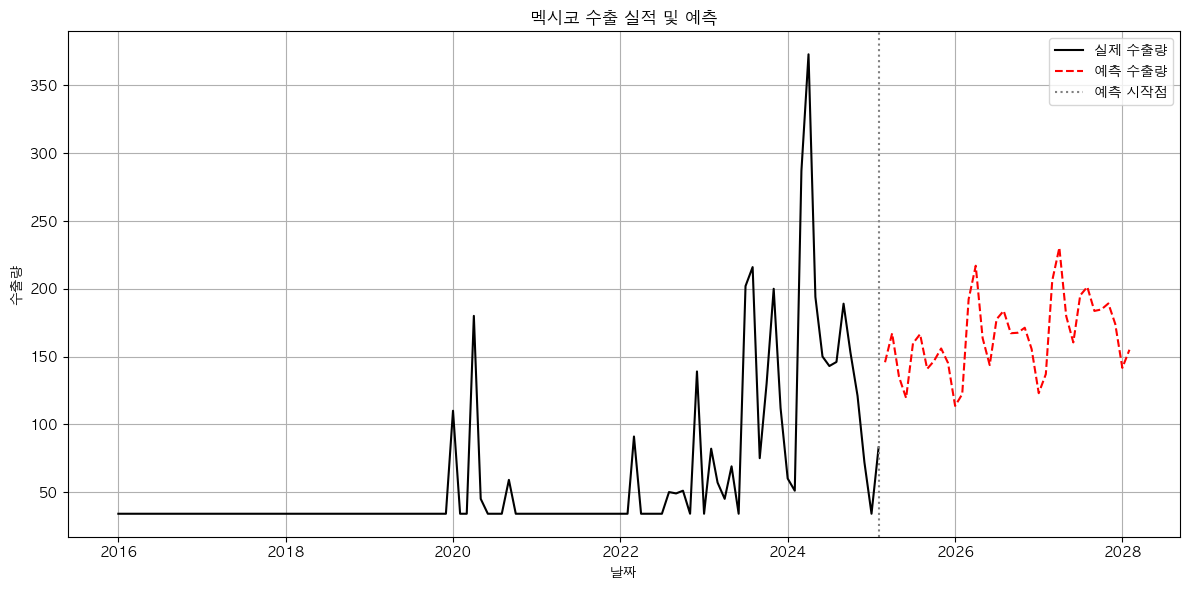

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def prepare_region_series(df, car_data):
    region_data = df[df['지역명'] == car_data].iloc[:, 2:].T
    region_data.columns = ['y']
    region_data.index = pd.to_datetime(region_data.index)
    region_data = region_data.asfreq('MS')
    return region_data

def train_sarimax_model(series):
    # (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,12): 기본 계절성 모델
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fit_model = model.fit(disp=False)
    return fit_model

def forecast_future(fit_model, series, periods):
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast = fit_model.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 수출량': forecast_mean.values
    })
    return result


file_path = "../../data/processed/현대_차종별판매실적_전처리.csv"  # 본인 환경에 맞게 경로 설정
region_name = ""  # 입력받을 지역명
forecast_months = 36   # 예측할 개월 수

df = load_data(file_path)
# df['지역명'] = df['지역명'].astype(str) + '-' + df['대륙'].astype(str).str.zfill(2)

# # 기존 컬럼 제거
# df = df.drop(columns=['대륙'])

# # '날짜' 컬럼을 맨 앞으로 이동
# cols = ['지역명'] + [col for col in df.columns if col != '지역명']
# df = df[cols]
region_series = prepare_region_series(df, region_name)
model = train_sarimax_model(region_series)
forecast_result = forecast_future(model, region_series, forecast_months)

print(forecast_result)

import matplotlib.pyplot as plt

def plot_series_with_forecast(series, forecast_result, region_name):
    # 실제값
    actual = series.copy()
    
    # 예측 날짜 구성
    forecast_index = pd.to_datetime(forecast_result['연도'].astype(str) + '-' + forecast_result['월'].astype(str))
    forecast_series = pd.Series(forecast_result['예측 수출량'].values, index=forecast_index)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual['y'], label='실제 수출량', color='black')
    plt.plot(forecast_series.index, forecast_series.values, label='예측 수출량', color='red', linestyle='--')
    
    plt.axvline(x=actual.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title(f"{region_name} 수출 실적 및 예측")
    plt.xlabel("날짜")
    plt.ylabel("수출량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_series_with_forecast(region_series, forecast_result, region_name)

In [21]:
df

,차량,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
0,Accent (RB)-승용차-내수,1016,1047,1735,1351,1292,1576,827,860,687,...,310,310,310,310,310,310,310,310,310,310
1,Avante (AD)-승용차-내수,6996,7932,8751,7628,8472,12363,6243,6756,5135,...,2263,2263,2263,2263,2263,2263,2263,2263,2263,2263
2,Avante (CN7)-승용차-내수,2425,2425,2425,2425,2425,2425,2425,2425,2425,...,5226,4196,3458,3450,3290,5411,4787,5766,4086,4658
3,Avante (CN7 HEV)-승용차-내수,272,272,272,272,272,272,272,272,272,...,432,468,415,435,396,517,496,617,1233,1445
4,Avante (CN7 N)-승용차-내수,67,67,67,67,67,67,67,67,67,...,135,142,102,67,67,67,169,79,144,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,nan-nan-nan,45,45,45,45,45,45,45,45,45,...,45,152,45,45,45,45,45,45,45,45
434,nan-nan-nan,923,923,923,923,923,923,923,923,923,...,3042,2115,1633,1896,1068,2345,2490,2345,1984,2415
435,nan-nan-nan,148,148,148,148,148,148,148,148,148,...,472,295,278,320,278,374,303,399,370,444
436,nan-nan-nan,4727,4774,5277,4825,3819,4051,3501,2149,3486,...,2526,3370,2988,3490,3007,3552,3431,3364,2891,3593


In [ ]:
df.fillna